In [46]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [47]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=5, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [48]:
arxiv.invoke("Attention all we need")

'Published: 2017-09-19\nTitle: Exploring Human-like Attention Supervision in Visual Question Answering\nAuthors: Tingting Qiao, Jianfeng Dong, Duanqing Xu\nSummary: Attention mechanisms have been widely applied in the Visual Question\nAnswering (VQA) task, as they help to focus on the area-of-interest of both\nvisual and textual information. To answer the questions correctly, the model\nneeds to selectively target different areas of an image, which suggests that an\nattention-based model may benefit fro'

In [49]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [50]:
wiki.invoke("Where is meghalaya")

'Page: Meghalaya\nSummary: Meghalaya (; lit. "the abode of clouds") is a state in northeast India. Its capital is Shillong. Meghalaya was formed on 21 January 1972 by carving out two districts from the Assam: the United Khasi Hills and Jaintia Hills and the Garo Hills. The estimated population of Meghalaya in 2014 was 3,211,474. Meghalaya covers an area of approximately 22,429 square kilometres, with a length-to-breadth ratio of about 3:1. The state is bound to the south by the Bangladeshi divisio'

In [51]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [52]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()


In [53]:
tavily.invoke("provide me the recent news of Assam")

[{'title': 'Assam News: Latest Updates & Breaking Headlines - India Today',
  'url': 'https://www.indiatoday.in/india/assam',
  'content': '### Download App\n\nDownload app\n\n# Assam News\n\n#### India News\n\n## Puri Rath Yatra stampede: 2 officials transferred after 3 killed, 50 injured\n\nPuri stampede: The incident took place near Saradhabali, in front of the temple, where Lord Jagannath was seated on the chariot.\n\nEmergency services responded quickly and the injured were taken to Puri District Hospital. Six of them are in critical condition. (PTI Photo)\n\n#### Assam News [...] A 4.2 magnitude earthquake hit Assam on Sunday morning, no injuries or damage were reported. The exact location of the earthquake epicentre is around 105 km north of Guwahati.\n\nEarthquake of 4.6 magnitude strikes Udalguri, shakes parts of Assam and Bhutan\n\n#### Assam News\n\n## Assam scraps 2-hour namaz breaks on Fridays, Opposition slams move\n\nAssam Chief Minister Himanta Biswa Sarma has scrapped 

In [54]:
tools=[arxiv,wiki,tavily]

In [55]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")

llm_with_tools= llm.bind_tools(tools)

In [56]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"what is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '31techqmj',
  'type': 'tool_call'}]

In [57]:
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

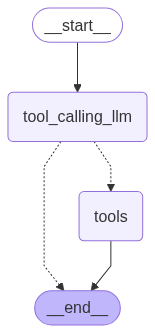

In [59]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", END)


graph= builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [60]:
messages=graph.invoke({"messages":HumanMessage(content="What is attention is all you need")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  wikipedia (ft4g9mvsh)
 Call ID: ft4g9mvsh
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [61]:
messages=graph.invoke({"messages":HumanMessage(content="provide me recent north east news")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

provide me recent north east news
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (myb1scncs)
 Call ID: myb1scncs
  Args:
    query: recent news north east
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "North East England news - Yahoo UK", "url": "https://uk.yahoo.com/topics/north-east-england-news/", "content": "### News\n\n### Life\n\n### Movies\n\n### Finance\n\n### Sport\n\n### UK English Select edition\n\n# Yahoo Home\n\n### Topic\n\n# North East England news\n\n#### Follow the latest news from Northumberland, Durham, Tyne & Wear, Newcastle and Sunderland including breaking stories, weather, travel and crime\n\n## Top North East stories\n\nChronicle Live\n\n### Train passenger left former pal with broken eye socket over 'comments about his mum'\n\nT

In [1]:
!pip install langchain-community

  Using cached langchain-0.3.26-py3-none-any.whl.metadata (7.8 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached langchain_text_splitters-0.3.8-py3-none-any.whl.metadata (1.9 kB)
  Using cached mypy_extensions-1.1.0-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 885.6 kB/s eta 0:00:03
   -------- ------------------------------- 0.5/2.5 MB 885.6 kB/s eta 0:00:03


In [5]:
!pip install arxiv

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6105 sha256=9565baff07269c84e628844b6df1ff36c0e6b4d4ccacfb2c478ecd9f2d85f9e3
  Stored in directory: c:\users\aijul\appdata\local\pip\cache\wheels\03\f5\1a\23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k

   ---------------------------------------- 3/3 [arxiv]



  DEPRECATION: Building 'sgmllib3k' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'sgmllib3k'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [6]:
!pip install wikipedia

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11785 sha256=b22e25730c00bd351d321d076118b7f6870a165c25a6e8ddd19d5cb34ea791b4
  Stored in directory: c:\users\aijul\appdata\local\pip\cache\wheels\63\47\7c\a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia

   ------------- -------------------------- 1/3 [beautifulsoup4]
   ---------------------------------------- 3/3 [wikipedia]



  DEPRECATION: Building 'wikipedia' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'wikipedia'. Discussion can be found at https://github.com/pypa/pip/issues/6334
